# Evaluation Dashboard Prototyping

This is a starter notebook. We'll fill it in Step 2.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

curve = pd.read_csv(PROC / "policy_curve_email.csv")
deciles = pd.read_csv(PROC / "hillstrom_uplift_deciles.csv")
try:
    clv = pd.read_csv(PROC / "clv_scores_h180.csv")     # from 01 notebook
except FileNotFoundError:
    clv = None

len(curve), deciles.head()


(16000,
       n     cum_gain  cum_gain_per_customer
 0  1600  1671.495720               1.044685
 1  3200  2234.158113               0.698174
 2  4800  5416.774770               1.128495
 3  6400  5936.907457               0.927642
 4  8000  6924.475859               0.865559)

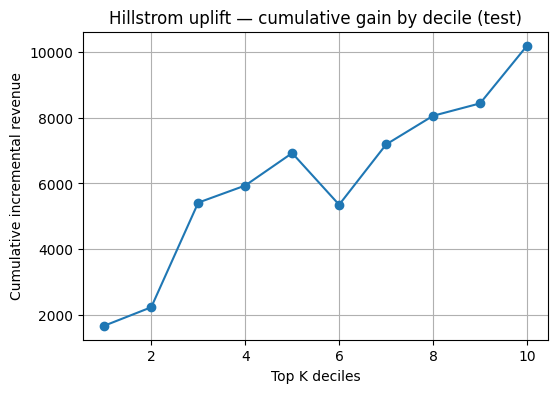

,n,cum_gain,cum_gain_per_customer
0,1600,1671.495720,1.044685
1,3200,2234.158113,0.698174
2,4800,5416.774770,1.128495
3,6400,5936.907457,0.927642
4,8000,6924.475859,0.865559
5,9600,5353.296828,0.557635
6,11200,7187.110750,0.641706
7,12800,8058.977127,0.629608
8,14400,8436.671680,0.585880
9,16000,10191.235193,0.636952


In [2]:
fig = plt.figure(figsize=(6,4))
plt.plot(deciles.index+1, deciles["cum_gain"], marker="o")
plt.title("Hillstrom uplift — cumulative gain by decile (test)")
plt.xlabel("Top K deciles")
plt.ylabel("Cumulative incremental revenue")
plt.grid(True)
plt.show()

deciles


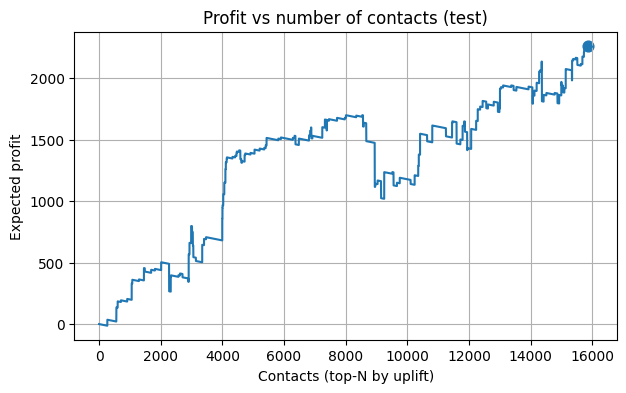

Best N: 15855 (99.09% of customers)  |  Profit ≈ 2264.62


In [3]:
best_idx = int(curve["profit"].idxmax())
best_row = curve.iloc[best_idx]

fig = plt.figure(figsize=(7,4))
plt.plot(curve["n"], curve["profit"])
plt.scatter([best_row["n"]],[best_row["profit"]], s=60)
plt.title("Profit vs number of contacts (test)")
plt.xlabel("Contacts (top-N by uplift)")
plt.ylabel("Expected profit")
plt.grid(True)
plt.show()

print(f"Best N: {int(best_row['n'])} "
      f"({100*best_row['n']/len(curve):.2f}% of customers)  |  "
      f"Profit ≈ {best_row['profit']:.2f}")


In [4]:
contacts = pd.read_csv(PROC / "policy_contact_list.csv")
contacts.head(15)


,row_id,uplift_hat,rank
0,11786,267.869600,1
1,13574,235.279467,2
2,8911,164.670000,3
3,9527,146.373333,4
4,10755,136.221167,5
5,10271,122.005300,6
6,3177,120.406233,7
7,7190,116.433333,8
8,9130,114.025333,9
9,11706,105.179967,10


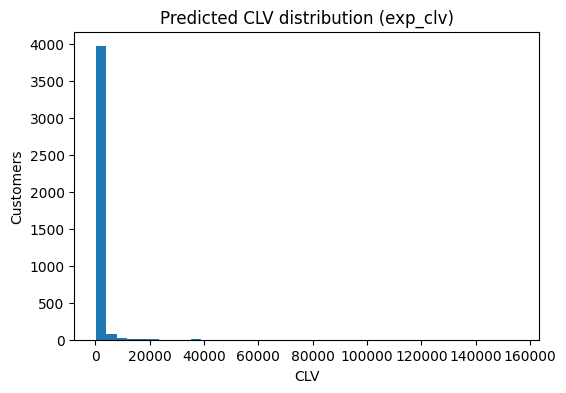

In [6]:
# Cell E — robust to either naming scheme
if clv is not None:
    # pick the right column names if they exist
    clv_col = next((c for c in ["exp_clv_h180", "exp_clv", "exp_clv_h365"]
                    if c in clv.columns), None)
    purch_col = next((c for c in ["exp_purchases_h180", "exp_purchases"]
                      if c in clv.columns), None)
    aov_col = "exp_aov" if "exp_aov" in clv.columns else None

    if clv_col:
        plt.figure(figsize=(6, 4))
        plt.hist(clv[clv_col], bins=40)
        plt.title(f"Predicted CLV distribution ({clv_col})")
        plt.xlabel("CLV"); plt.ylabel("Customers")
        plt.show()
    else:
        print("No CLV-like column found. Available columns:", list(clv.columns))

    # Show summary for whatever columns we found
    cols_to_describe = [c for c in [clv_col, aov_col, purch_col] if c]
    if cols_to_describe:
        clv[cols_to_describe].describe()
else:
    print("CLV file not found (skipping).")


In [7]:
def best_pct_for(margin_rate, email_cost):
    profit = margin_rate*curve["cum_gain_revenue"] - email_cost*curve["n"]
    i = int(profit.idxmax())
    return round(100 * curve.iloc[i]["n"] / len(curve), 2), float(profit.iloc[i])

grid = []
for m in [0.15, 0.2, 0.25, 0.30, 0.35]:
    for c in [0.03, 0.05, 0.07, 0.10, 0.15]:
        pct, prof = best_pct_for(m, c)
        grid.append({"margin_rate": m, "email_cost": c, "best_pct": pct, "profit_at_best": round(prof,2)})

sens = pd.DataFrame(grid)
sens_pivot = sens.pivot(index="margin_rate", columns="email_cost", values="best_pct").sort_index(ascending=True)
sens.to_csv(PROC / "policy_sensitivity.csv", index=False)
sens_pivot


email_cost,0.03,0.05,0.07,0.10,0.15
margin_rate,,,,,
0.15,99.09,99.09,33.97,25.92,25.92
0.20,99.09,99.09,99.09,33.97,25.92
0.25,99.09,99.09,99.09,99.09,27.94
0.30,99.09,99.09,99.09,99.09,33.97
0.35,99.09,99.09,99.09,99.09,45.80


In [8]:
from pathlib import Path
import numpy as np, pandas as pd

# paths
PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

# business knobs (same as in 03)
margin_rate = 0.30   # 30% gross margin on incremental spend
email_cost  = 0.05   # $0.05 per send

# best N from the profit curve you saved
curve = pd.read_csv(PROC / "policy_curve_email.csv")
best_row = curve.loc[curve["profit"].idxmax()]
best_n   = int(best_row["n"])
best_p   = float(best_row["profit"])

# load individual uplift scores (test set)
scores = pd.read_csv(PROC / "hillstrom_uplift_scores_test.csv")

# sort & compute per-contact economics
scores = scores.sort_values("uplift_hat", ascending=False).reset_index(drop=True)
scores["rank"] = np.arange(1, len(scores) + 1)

# uplift_hat is incremental spend; treat negative uplift as 0 for economics
scores["exp_incremental_revenue"] = scores["uplift_hat"].clip(lower=0.0)
scores["exp_profit_per_contact"]  = margin_rate * scores["exp_incremental_revenue"] - email_cost

# ------- Variant A: Top-N by uplift (the policy you optimized) -------
final_top = scores.head(best_n).copy()
summary_top = {
    "contacts": best_n,
    "expected_incremental_revenue": final_top["exp_incremental_revenue"].sum(),
    "expected_cost": email_cost * best_n,
    "expected_profit": margin_rate * final_top["exp_incremental_revenue"].sum() - email_cost * best_n,
}
pd.Series(summary_top).round(2)

out_top = PROC / "final_contact_list_email.csv"
final_top[["row_id", "uplift_hat", "exp_profit_per_contact", "rank"]].to_csv(out_top, index=False)
print("Saved:", out_top)

# ------- Variant B: Only contacts with positive marginal profit -------
pos = scores.loc[scores["exp_profit_per_contact"] > 0].copy()
summary_pos = {
    "contacts": len(pos),
    "expected_incremental_revenue": pos["exp_incremental_revenue"].sum(),
    "expected_cost": email_cost * len(pos),
    "expected_profit": margin_rate * pos["exp_incremental_revenue"].sum() - email_cost * len(pos),
}
print("\nPositive-marginal-only summary:")
print(pd.Series(summary_pos).round(2))

pos_out = PROC / "final_contact_list_email_positive_only.csv"
pos[["row_id", "uplift_hat", "exp_profit_per_contact", "rank"]].to_csv(pos_out, index=False)
print("Saved:", pos_out)

# quick peek
final_top.head(10)


Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\final_contact_list_email.csv

Positive-marginal-only summary:
contacts                         4430.00
expected_incremental_revenue    20900.45
expected_cost                     221.50
expected_profit                  6048.64
dtype: float64
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\final_contact_list_email_positive_only.csv


,row_id,uplift_hat,y_actual,treated,ipw_contrib,rank,exp_incremental_revenue,exp_profit_per_contact
0,11786,267.869600,0.0,0,-0.0,1,267.869600,80.31088
1,13574,235.279467,0.0,1,0.0,2,235.279467,70.53384
2,8911,164.670000,0.0,1,0.0,3,164.670000,49.35100
3,9527,146.373333,0.0,1,0.0,4,146.373333,43.86200
4,10755,136.221167,0.0,1,0.0,5,136.221167,40.81635
5,10271,122.005300,0.0,1,0.0,6,122.005300,36.55159
6,3177,120.406233,0.0,1,0.0,7,120.406233,36.07187
7,7190,116.433333,0.0,0,-0.0,8,116.433333,34.88000
8,9130,114.025333,0.0,1,0.0,9,114.025333,34.15760
9,11706,105.179967,0.0,1,0.0,10,105.179967,31.50399


In [9]:
print(f"Optimal policy: contact {best_n} customers "
      f"({round(100*best_n/len(scores),2)}% of test set) | "
      f"Profit ≈ {best_p:.2f}")


Optimal policy: contact 15855 customers (99.09% of test set) | Profit ≈ 2264.62


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW  = PROJ / "data" / "raw"
PROC = PROJ / "data" / "processed"
OUTD = PROC / "audiences"
OUTD.mkdir(parents=True, exist_ok=True)

# Assumptions (match earlier work)
MARGIN = 0.30
EMAIL_COST = 0.05

# Inputs we already produced
scores_full = pd.read_csv(PROC / "hillstrom_uplift_scores_test.csv")  # row_id, uplift_hat, y_actual, treated, ipw_contrib
curve       = pd.read_csv(PROC / "policy_curve_email.csv")            # for reference
deciles     = pd.read_csv(PROC / "hillstrom_uplift_deciles.csv")      # for reference

# Contact lists from step 03/04
topN_raw    = pd.read_csv(PROC / "final_contact_list_email.csv")                  # row_id, uplift_hat, rank
pos_raw     = pd.read_csv(PROC / "final_contact_list_email_positive_only.csv")    # may already include exp_* cols

# Original Hillstrom features (we saved this earlier in 02)
hill = pd.read_csv(RAW / "hillstrom.csv")

# --- derive decile for every scored row (top decile = 10) ---
r = scores_full["uplift_hat"].rank(method="first", ascending=False)
scores_full["uplift_decile"] = pd.qcut(r, 10, labels=list(range(10,0,-1))).astype(int)

# expected incremental revenue and profit per contact (recompute to be safe)
scores_full["exp_incremental_revenue"] = scores_full["uplift_hat"]
scores_full["exp_profit_per_contact"]  = MARGIN * scores_full["exp_incremental_revenue"] - EMAIL_COST

# Helper to assemble a clean table
keep_cols = [
    "row_id","rank","uplift_decile","uplift_hat","exp_incremental_revenue","exp_profit_per_contact",
    "y_actual","treated","ipw_contrib"
]

def enrich(contact_df, label):
    df = (contact_df
          .merge(scores_full, on="row_id", how="left")
          .merge(hill.reset_index().rename(columns={"index":"row_id"}), on="row_id", how="left"))
    # Order & tidy
    base_cols = [c for c in keep_cols if c in df.columns]
    feat_cols = [c for c in hill.columns if c not in ["spend","treatment"]]  # keep descriptive features
    ordered   = base_cols + feat_cols + [c for c in df.columns if c not in base_cols+feat_cols]
    df = df[ordered].sort_values("rank", ascending=True, na_position="last")
    df.insert(0, "audience", label)
    df.insert(1, "should_contact", 1)
    df.insert(2, "policy_margin", MARGIN)
    df.insert(3, "contact_cost", EMAIL_COST)
    return df

final_top = enrich(topN_raw, "topN_by_uplift")
final_pos = enrich(pos_raw, "positive_only")

# Save CSVs
top_path = OUTD / "final_contacts_topN_with_features.csv"
pos_path = OUTD / "final_contacts_positive_only_with_features.csv"
full_scored = OUTD / "full_scored_test_set.csv"

final_top.to_csv(top_path, index=False)
final_pos.to_csv(pos_path, index=False)
scores_full.to_csv(full_scored, index=False)

print("Saved:")
print(" •", top_path)
print(" •", pos_path)
print(" •", full_scored)

# Quick rollups
def summarize(df, name):
    n = len(df)
    rev = df["exp_incremental_revenue"].sum()
    prof = (MARGIN*df["exp_incremental_revenue"] - EMAIL_COST).sum()
    print(f"{name}: n={n:,} | expected_rev≈{rev:,.2f} | expected_profit≈{prof:,.2f}")

summarize(final_top, "TOP-N audience")
summarize(final_pos, "POS-ONLY audience")

final_top.head(10)


Saved:
 • C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\audiences\final_contacts_topN_with_features.csv
 • C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\audiences\final_contacts_positive_only_with_features.csv
 • C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\audiences\full_scored_test_set.csv
TOP-N audience: n=15,855 | expected_rev≈15,741.47 | expected_profit≈3,929.69
POS-ONLY audience: n=4,430 | expected_rev≈20,900.45 | expected_profit≈6,048.64


,audience,should_contact,policy_margin,contact_cost,row_id,rank,uplift_decile,exp_incremental_revenue,y_actual,treated,...,womens,zip_code,newbie,channel,uplift_hat_x,exp_profit_per_contact_x,uplift_hat_y,exp_profit_per_contact_y,spend,treatment
0,topN_by_uplift,1,0.3,0.05,11786,1,10,267.869600,0.0,0,...,0,Surburban,0,Web,267.869600,80.31088,267.869600,80.31088,0.0,Womens E-Mail
1,topN_by_uplift,1,0.3,0.05,13574,2,10,235.279467,0.0,1,...,0,Surburban,1,Phone,235.279467,70.53384,235.279467,70.53384,0.0,No E-Mail
2,topN_by_uplift,1,0.3,0.05,8911,3,10,164.670000,0.0,1,...,1,Surburban,0,Phone,164.670000,49.35100,164.670000,49.35100,0.0,Mens E-Mail
3,topN_by_uplift,1,0.3,0.05,9527,4,10,146.373333,0.0,1,...,1,Rural,0,Web,146.373333,43.86200,146.373333,43.86200,0.0,No E-Mail
4,topN_by_uplift,1,0.3,0.05,10755,5,10,136.221167,0.0,1,...,1,Urban,0,Phone,136.221167,40.81635,136.221167,40.81635,0.0,Womens E-Mail
5,topN_by_uplift,1,0.3,0.05,10271,6,10,122.005300,0.0,1,...,1,Urban,1,Phone,122.005300,36.55159,122.005300,36.55159,0.0,Mens E-Mail
6,topN_by_uplift,1,0.3,0.05,3177,7,10,120.406233,0.0,1,...,1,Urban,0,Phone,120.406233,36.07187,120.406233,36.07187,0.0,Womens E-Mail
7,topN_by_uplift,1,0.3,0.05,7190,8,10,116.433333,0.0,0,...,0,Surburban,0,Web,116.433333,34.88000,116.433333,34.88000,0.0,Mens E-Mail
8,topN_by_uplift,1,0.3,0.05,9130,9,10,114.025333,0.0,1,...,1,Surburban,0,Multichannel,114.025333,34.15760,114.025333,34.15760,0.0,Mens E-Mail
9,topN_by_uplift,1,0.3,0.05,11706,10,10,105.179967,0.0,1,...,1,Surburban,0,Web,105.179967,31.50399,105.179967,31.50399,0.0,Womens E-Mail


In [13]:
import sys, subprocess, importlib

def ensure(package, pip_name=None):
    pip_name = pip_name or package
    try:
        importlib.import_module(package)
        print(f"{package} already installed")
    except ImportError:
        print(f"installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        importlib.import_module(package)
        print(f"{package} ready")

ensure("seaborn")
ensure("xlsxwriter")


seaborn already installed
xlsxwriter already installed


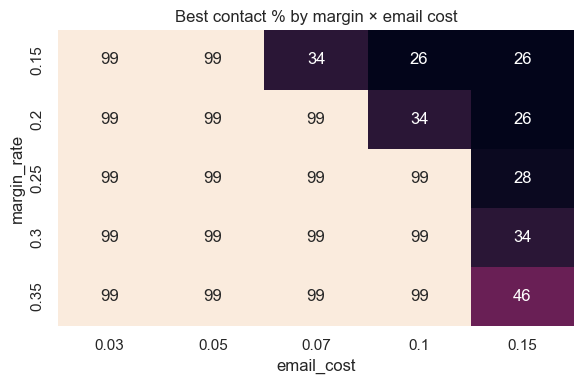

Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\figs\policy_sensitivity_heatmap.png


C:\Users\balla\AppData\Local\Temp\ipykernel_26812\255320465.py:24: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.read_csv(PROC / "policy_curve_email.csv").to_excel(xw, "policy_curve", index=False)
C:\Users\balla\AppData\Local\Temp\ipykernel_26812\255320465.py:25: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.read_csv(PROC / "hillstrom_uplift_deciles.csv").to_excel(xw, "uplift_deciles", index=False)
C:\Users\balla\AppData\Local\Temp\ipykernel_26812\255320465.py:26: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  sens.to_excel(xw, "policy_sensitivity_grid", index=False)
C:\Users\balla\AppData\Local\Temp\ipykernel_26812\255320465.py:27: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except 

Saved Excel pack: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\policy_pack.xlsx


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set()

sens = pd.read_csv(PROC / "policy_sensitivity.csv")  # columns: margin_rate, email_cost, best_pct, profit_at_best
pvt  = sens.pivot(index="margin_rate", columns="email_cost", values="best_pct").sort_index()

FIGD = PROC / "figs"
FIGD.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6,4))
sns.heatmap(pvt, annot=True, fmt=".0f", cbar=False)
plt.title("Best contact % by margin × email cost")
plt.ylabel("margin_rate"); plt.xlabel("email_cost")
heat_path = FIGD / "policy_sensitivity_heatmap.png"
plt.tight_layout(); plt.savefig(heat_path, dpi=150); plt.show()
print("Saved:", heat_path)

# Single Excel pack with all artifacts managers love
pack_path = PROC / "policy_pack.xlsx"
with pd.ExcelWriter(pack_path, engine="xlsxwriter") as xw:
    pd.read_csv(PROC / "policy_curve_email.csv").to_excel(xw, "policy_curve", index=False)
    pd.read_csv(PROC / "hillstrom_uplift_deciles.csv").to_excel(xw, "uplift_deciles", index=False)
    sens.to_excel(xw, "policy_sensitivity_grid", index=False)
    final_top.head(2000).to_excel(xw, "topN_contacts_sample", index=False)
    final_pos.head(2000).to_excel(xw, "pos_only_sample", index=False)
print("Saved Excel pack:", pack_path)


In [15]:
import sys, subprocess, os, json, pathlib
nb_name = "04_eval_dashboard_prototyping.ipynb"
html_out = PROC / "reports"
html_out.mkdir(parents=True, exist_ok=True)

# Install nbconvert if missing
try:
    import nbconvert  # noqa
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nbconvert>=7"])

cmd = [
    sys.executable, "-m", "jupyter", "nbconvert",
    "--to", "html",
    "--output-dir", str(html_out),
    nb_name
]
print("Running:", " ".join(cmd))
subprocess.check_call(cmd)
print("Dashboard saved to:", html_out)


Running: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\.venv\Scripts\python.exe -m jupyter nbconvert --to html --output-dir C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\reports 04_eval_dashboard_prototyping.ipynb
Dashboard saved to: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\reports


In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

# Folders
PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"
REPD = PROC / "reports"
REPD.mkdir(parents=True, exist_ok=True)

# Load artifacts we already created earlier
curve      = pd.read_csv(PROC / "policy_curve_email.csv")           # has columns n, profit, etc.
deciles    = pd.read_csv(PROC / "hillstrom_uplift_deciles.csv")     # has n, cum_gain
final_top  = pd.read_csv(PROC / "final_contact_list_email.csv")     # ranked by uplift
final_pos  = pd.read_csv(PROC / "final_contact_list_email_positive_only.csv")  # only rows with positive per-contact profit

# Business settings used during this run (match what you used earlier)
policy_margin = 0.30
contact_cost  = 0.05

# Best-N from the profit curve
best_i   = int(curve["profit"].idxmax())
best_n   = int(curve.loc[best_i, "n"])
best_pct = round(100 * best_n / len(curve), 2)
best_p   = float(curve.loc[best_i, "profit"])
avg_gain_per_contact_at_best = float((curve.loc[best_i, "cum_gain_revenue"] if "cum_gain_revenue" in curve.columns else deciles.loc[best_i,"cum_gain"]) / max(best_n,1))

# Positive-margin-only policy (already filtered)
pos_n     = int(final_pos.shape[0])
pos_profit= float(final_pos["exp_profit_per_contact"].sum()) if "exp_profit_per_contact" in final_pos.columns else float(np.nan)
pos_rev   = float(final_pos["exp_incremental_revenue"].sum()) if "exp_incremental_revenue" in final_pos.columns else float(np.nan)
pos_cost  = round(contact_cost * pos_n, 2)

# Compact contact files for execution systems
min_cols = [c for c in ["row_id","uplift_hat","rank"] if c in final_top.columns]
(final_top[min_cols].head(50000)).to_csv(PROC / "contact_list_email_min.csv", index=False)
(final_pos[min_cols].head(50000)).to_csv(PROC / "contact_list_email_positive_only_min.csv", index=False)

# Simple AUUC-style summary (area under cumulative gain curve over 10 deciles)
x = deciles["n"] / deciles["n"].iloc[-1]
y = deciles["cum_gain"]
auuc = float(np.trapz(y, x))

summary_md = f"""
# Uplift Policy — Executive Summary
_Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}_

**Dataset:** Hillstrom test set  
**Margin:** {policy_margin:.2f} • **Contact cost:** {contact_cost:.2f}

## 1) Best-N policy (by expected profit)
- Contact **{best_n}** customers (**{best_pct}%** of test)
- **Expected Profit ≈ {best_p:,.2f}**
- Avg incremental revenue/contact at best N ≈ **{avg_gain_per_contact_at_best:,.3f}**

## 2) Positive-margin-only policy
- Contact **{pos_n}** customers
- **Expected Profit ≈ {pos_profit:,.2f}** (Rev ≈ {pos_rev:,.2f}, Cost ≈ {pos_cost:,.2f})
- _Note:_ This policy keeps only customers with **positive expected profit per contact**.

## 3) Uplift curve quality
- Approx. AUUC (decile gain area) ≈ **{auuc:,.2f}**

## Artifacts
- `data/processed/policy_pack.xlsx`
- `data/processed/figs/policy_sensitivity_heatmap.png`
- `data/processed/reports/` (HTML dashboard)
- Contact lists:
  - `data/processed/final_contact_list_email.csv` (ranked)
  - `data/processed/final_contact_list_email_positive_only.csv` (pos-only)
  - `data/processed/contact_list_email_min.csv`
  - `data/processed/contact_list_email_positive_only_min.csv`
"""

(REPD / "executive_summary.md").write_text(summary_md, encoding="utf-8")
print("Wrote:", REPD / "executive_summary.md")
print("Also wrote minimal contact lists in:", PROC)


Wrote: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\reports\executive_summary.md
Also wrote minimal contact lists in: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed


C:\Users\balla\AppData\Local\Temp\ipykernel_26812\1855286459.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auuc = float(np.trapz(y, x))


In [17]:
import zipfile, os
from pathlib import Path

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"
REPD = PROC / "reports"
FIGD = PROC / "figs"

to_zip = [
    PROC / "policy_curve_email.csv",
    PROC / "hillstrom_uplift_deciles.csv",
    PROC / "policy_sensitivity.csv",
    PROC / "final_contact_list_email.csv",
    PROC / "final_contact_list_email_positive_only.csv",
    PROC / "contact_list_email_min.csv",
    PROC / "contact_list_email_positive_only_min.csv",
    PROC / "policy_pack.xlsx",
    FIGD / "policy_sensitivity_heatmap.png",
    REPD / "executive_summary.md",
]

# Include any HTML dashboard(s) in reports
for p in (REPD.glob("*.html")):
    to_zip.append(p)

zip_path = PROC / "deliverables.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in to_zip:
        if p.exists():
            z.write(p, p.relative_to(PROC))
        else:
            print("Missing (skipped):", p.name)

print("Created:", zip_path)


Created: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\deliverables.zip


In [18]:
import sys, subprocess, pathlib
PROJ = pathlib.Path.cwd().parents[0] if pathlib.Path.cwd().name == "notebooks" else pathlib.Path.cwd()
out = (PROJ / "requirements.lock.txt")
txt = subprocess.check_output([sys.executable, "-m", "pip", "freeze", "--local"]).decode("utf-8")
out.write_text(txt, encoding="utf-8")
print("Wrote:", out)

Wrote: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\requirements.lock.txt


In [20]:
from pathlib import Path
import pandas as pd, subprocess, sys

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW  = PROJ / "data" / "raw"
PROC = PROJ / "data" / "processed"

input_csv  = RAW  / "hillstrom.csv"
output_csv = PROC / "cli_sanity_contacts.csv"

cmd = [
    sys.executable, str(PROJ / "tools" / "score_contacts.py"),
    "--in",   str(input_csv),
    "--out",  str(output_csv),
    "--policy", "bestN",
    "--margin", "0.30",
    "--cost",   "0.05",
    "--models", str(PROJ / "models"),   # <<< important
]

print("Running:", " ".join(cmd))
res = subprocess.run(cmd, capture_output=True, text=True)
print(res.stdout)
print(res.stderr)
res.check_returncode()   

cli = pd.read_csv(output_csv)
print("CLI top5:\n", cli.head())
print("Rows:", len(cli))

Running: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\.venv\Scripts\python.exe C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\tools\score_contacts.py --in C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\raw\hillstrom.csv --out C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\cli_sanity_contacts.csv --policy bestN --margin 0.30 --cost 0.05 --models C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\models
Contacts: 15157  |  Expected revenue: 80,787.36  |  Cost: 757.85  |  Profit: 23,478.36
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\cli_sanity_contacts.csv


CLI top5:
    row_id  rank  uplift_hat      y1_hat  y0_hat  exp_incremental_revenue  \
0   23393     1  331.003333  331.003333     0.0               331.003333   
1   40299     2  323.446100  323.446100     0.0               32

In [26]:
import pandas as pd
from pathlib import Path

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

nb  = pd.read_csv(PROC / "nb_scored_test.csv")                         # from notebook
cli = pd.read_csv(PROC / "cli_sanity_contacts_test.csv")               # from CLI

# keep only what's needed and align names
cli = cli[["row_id","uplift_hat"]].rename(columns={"uplift_hat":"uplift_cli"})

cmp = nb.merge(cli, on="row_id", how="inner")
print("Rows in common:", len(cmp), " / ", len(nb))

# correlation & error stats
corr = cmp[["uplift_hat","uplift_cli"]].corr().iloc[0,1]
cmp["diff"] = cmp["uplift_hat"] - cmp["uplift_cli"]
print(f"Pearson corr: {corr:.6f}")
print("95th pct abs diff:", cmp["diff"].abs().quantile(0.95))

# top-k overlap (should be ~100% if everything lines up)
k = 1000
nb_top  = set(cmp.sort_values("uplift_hat", ascending=False).head(k)["row_id"])
cli_top = set(cmp.sort_values("uplift_cli",  ascending=False).head(k)["row_id"])
print(f"Top-{k} overlap: {len(nb_top & cli_top)/k:.3f}")

# peek biggest mismatches (optional)
cmp.assign(absdiff=cmp["diff"].abs()).sort_values("absdiff", ascending=False).head(10)


Rows in common: 3724  /  16000
Pearson corr: 1.000000
95th pct abs diff: 0.0
Top-1000 overlap: 1.000


,row_id,uplift_hat,uplift_cli,diff,absdiff
554,2359,46.816699,46.816699,-7.105427e-15,7.105427e-15
2122,9108,46.816699,46.816699,-7.105427e-15,7.105427e-15
2380,10206,46.816699,46.816699,-7.105427e-15,7.105427e-15
901,3861,46.816699,46.816699,-7.105427e-15,7.105427e-15
2926,12584,46.816699,46.816699,-7.105427e-15,7.105427e-15
1776,7582,12.356691,12.356691,3.552714e-15,3.552714e-15
879,3744,12.356691,12.356691,3.552714e-15,3.552714e-15
782,3313,16.424100,16.424100,3.552714e-15,3.552714e-15
781,3310,12.356691,12.356691,3.552714e-15,3.552714e-15
840,3595,12.356691,12.356691,3.552714e-15,3.552714e-15


In [27]:
from pathlib import Path
import pandas as pd, json, joblib
import numpy as np

# Paths
PROJ   = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW    = PROJ / "data" / "raw"
PROC   = PROJ / "data" / "processed"
MODELS = PROJ / "models"

# Load data & CLI output
df  = pd.read_csv(RAW / "hillstrom_test_only.csv")              # 16,000 rows
cli = pd.read_csv(PROC / "cli_all_scored_test.csv")             # produced by the CLI

# Load artifacts
enc   = joblib.load(MODELS / "preprocess.joblib")
reg_t = joblib.load(MODELS / "rf_treated.joblib")
reg_c = joblib.load(MODELS / "rf_control.joblib")
meta  = json.load(open(MODELS / "meta.json"))

# Build features exactly as trained
feat_cols = meta["feature_cols"]
X = df[feat_cols].copy()
for c in meta["cat_cols"]:
    if c in X.columns:
        X[c] = X[c].astype(str)

# Predict with saved models
A  = enc.transform(X)
y1 = reg_t.predict(A)
y0 = reg_c.predict(A)
nb = pd.DataFrame({"row_id": df.get("row_id", pd.RangeIndex(len(df))), "uplift_hat": y1 - y0})

# Compare with CLI
cmp = nb.merge(
    cli[["row_id", "uplift_hat"]].rename(columns={"uplift_hat":"uplift_cli"}),
    on="row_id", how="inner"
)
diff = (cmp["uplift_hat"] - cmp["uplift_cli"]).abs()

print("Rows in common:", len(cmp), "/", len(df))
print("Pearson corr:  ", round(cmp["uplift_hat"].corr(cmp["uplift_cli"]), 6))
print("95th pct abs diff:", float(diff.quantile(0.95)))

# Top-K overlap (rank agreement)
k = 1000
nb_top  = set(nb.sort_values("uplift_hat", ascending=False)["row_id"].head(k))
cli_top = set(cli.sort_values("uplift_hat", ascending=False)["row_id"].head(k))
overlap = len(nb_top & cli_top) / k
print(f"Top-{k} overlap:", round(overlap, 3))

# Peek at largest (absolute) mismatches
cmp.assign(absdiff=diff).sort_values("absdiff", ascending=False).head(10)


Rows in common: 16000 / 16000
Pearson corr:   1.0
95th pct abs diff: 1.1102230246251565e-16
Top-1000 overlap: 1.0


,row_id,uplift_hat,uplift_cli,absdiff
1654,1654,-136.393333,-136.393333,2.842171e-14
5998,5998,-97.958933,-97.958933,1.421085e-14
11290,11290,124.403000,124.403000,1.421085e-14
8061,8061,101.046000,101.046000,1.421085e-14
3316,3316,102.098000,102.098000,1.421085e-14
10274,10274,104.169433,104.169433,1.421085e-14
782,782,116.511967,116.511967,1.421085e-14
2220,2220,123.841867,123.841867,1.421085e-14
12416,12416,123.350933,123.350933,1.421085e-14
479,479,27.357494,27.357494,1.065814e-14


In [28]:
from pathlib import Path
import json, pandas as pd

PROJ   = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC   = PROJ / "data" / "processed"
MODELS = PROJ / "models"

meta = json.load(open(MODELS / "meta.json"))
feat_cols = meta["feature_cols"]
cat_cols  = set(meta["cat_cols"])

schema = pd.DataFrame({
    "column": feat_cols,
    "type": ["categorical" if c in cat_cols else "numeric" for c in feat_cols]
})

out_path = PROC / "required_features_schema.csv"
schema.to_csv(out_path, index=False)
print("Saved schema to:", out_path)
schema.head(20)


Saved schema to: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\required_features_schema.csv


,column,type
0,recency,numeric
1,history_segment,categorical
2,history,numeric
3,mens,numeric
4,womens,numeric
5,zip_code,categorical
6,newbie,numeric
7,channel,categorical


In [29]:
from pathlib import Path
import pandas as pd

PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

pd.read_csv(PROC / "scored_contacts.csv").head(10)


,row_id,rank,uplift_hat,y1_hat,y0_hat,exp_incremental_revenue,exp_profit_per_contact
0,10971,1,291.551400,291.551400,0.0,291.551400,87.415420
1,2296,2,252.400567,252.400567,0.0,252.400567,75.670170
2,2256,3,239.778933,239.778933,0.0,239.778933,71.883680
3,7128,4,204.590000,204.590000,0.0,204.590000,61.327000
4,12142,5,190.906333,190.906333,0.0,190.906333,57.221900
5,1219,6,169.828794,169.828794,0.0,169.828794,50.898638
6,634,7,164.670000,164.670000,0.0,164.670000,49.351000
7,14618,8,155.779767,155.779767,0.0,155.779767,46.683930
8,15004,9,130.611200,130.611200,0.0,130.611200,39.133360
9,12261,10,130.264667,130.264667,0.0,130.264667,39.029400


In [30]:
from pathlib import Path
import pandas as pd

# Paths
PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"

# Params used when you ran the CLI (keep these consistent)
margin_rate = 0.30
email_cost  = 0.05

# Load the scored file from the CLI
df = pd.read_csv(PROC / "scored_contacts.csv")

# Flag contacts with positive marginal profit
df["should_contact"] = (df["exp_profit_per_contact"] > 0).astype(int)

# Positive-profit segment (recommended default policy)
final = df[df["should_contact"] == 1].copy().reset_index(drop=True)

# KPIs
contacts = len(final)
expected_incremental_revenue = final["exp_incremental_revenue"].sum()
expected_cost   = email_cost * contacts
expected_profit = final["exp_profit_per_contact"].sum()  # already margin - cost per row

print(f"Contacts: {contacts}")
print(f"Expected incremental revenue: {expected_incremental_revenue:,.2f}")
print(f"Expected cost: {expected_cost:,.2f}")
print(f"Expected profit: {expected_profit:,.2f}")

# Save deliverables
out_contacts = PROC / "final_contact_list_email.csv"
out_full     = PROC / "scored_contacts_with_flag.csv"

final[["row_id","rank","uplift_hat","y1_hat","y0_hat",
       "exp_incremental_revenue","exp_profit_per_contact","should_contact"]].to_csv(out_contacts, index=False)
df.to_csv(out_full, index=False)

print("Saved:", out_contacts)
print("Saved:", out_full)

# quick peek
final.head(10)


Contacts: 3724
Expected incremental revenue: 19,038.28
Expected cost: 186.20
Expected profit: 5,525.28
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\final_contact_list_email.csv
Saved: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\scored_contacts_with_flag.csv


,row_id,rank,uplift_hat,y1_hat,y0_hat,exp_incremental_revenue,exp_profit_per_contact,should_contact
0,10971,1,291.551400,291.551400,0.0,291.551400,87.415420,1
1,2296,2,252.400567,252.400567,0.0,252.400567,75.670170,1
2,2256,3,239.778933,239.778933,0.0,239.778933,71.883680,1
3,7128,4,204.590000,204.590000,0.0,204.590000,61.327000,1
4,12142,5,190.906333,190.906333,0.0,190.906333,57.221900,1
5,1219,6,169.828794,169.828794,0.0,169.828794,50.898638,1
6,634,7,164.670000,164.670000,0.0,164.670000,49.351000,1
7,14618,8,155.779767,155.779767,0.0,155.779767,46.683930,1
8,15004,9,130.611200,130.611200,0.0,130.611200,39.133360,1
9,12261,10,130.264667,130.264667,0.0,130.264667,39.029400,1


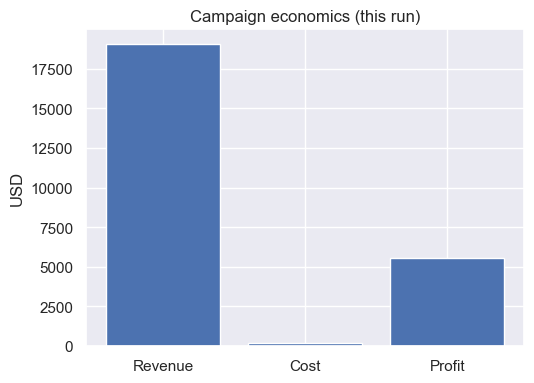

C:\Users\balla\AppData\Local\Temp\ipykernel_26812\120156410.py:54: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  summary.to_excel(xw, "summary", index=False)
C:\Users\balla\AppData\Local\Temp\ipykernel_26812\120156410.py:56: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  "exp_incremental_revenue","exp_profit_per_contact"]].to_excel(xw, "contacts", index=False)


Saved plot: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\figs\campaign_economics.png
Saved pack: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\contact_pack_20250919_0403.xlsx
Saved summary: C:\Users\balla\Downloads\clv-uplift-optimizer-starter\clv-uplift-optimizer\data\processed\contact_pack_20250919_0403.md


In [31]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# ---- paths
PROJ = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROC = PROJ / "data" / "processed"
FIGD = PROC / "figs"
FIGD.mkdir(parents=True, exist_ok=True)

# ---- load scored file with the flag we just wrote
df    = pd.read_csv(PROC / "scored_contacts_with_flag.csv")
final = df[df["should_contact"] == 1].copy().reset_index(drop=True)

# keep these consistent with your run
email_cost  = 0.05
margin_rate = 0.30

# ---- KPIs
contacts   = len(final)
population = len(df)
share_pct  = round(100 * contacts / population, 2)

exp_rev    = final["exp_incremental_revenue"].sum()
exp_cost   = email_cost * contacts
exp_profit = final["exp_profit_per_contact"].sum()

summary = pd.DataFrame([{
    "population": population,
    "contacts": contacts,
    "share_pct": share_pct,
    "margin_rate": margin_rate,
    "email_cost": email_cost,
    "expected_incremental_revenue": round(exp_rev, 2),
    "expected_cost": round(exp_cost, 2),
    "expected_profit": round(exp_profit, 2),
}])

# ---- quick visual
plt.figure(figsize=(5.5,4))
plt.bar(["Revenue","Cost","Profit"], [exp_rev, exp_cost, exp_profit])
plt.title("Campaign economics (this run)")
plt.ylabel("USD")
plt.tight_layout()
fig_path = FIGD / "campaign_economics.png"
plt.savefig(fig_path, dpi=150)
plt.show()

# ---- export a simple pack
stamp = datetime.now().strftime("%Y%m%d_%H%M")
pack_path = PROC / f"contact_pack_{stamp}.xlsx"
with pd.ExcelWriter(pack_path, engine="xlsxwriter") as xw:
    summary.to_excel(xw, "summary", index=False)
    final[["row_id","rank","uplift_hat","y1_hat","y0_hat",
           "exp_incremental_revenue","exp_profit_per_contact"]].to_excel(xw, "contacts", index=False)

# lightweight text summary for email/Slack
md_path = PROC / f"contact_pack_{stamp}.md"
md = (
f"# Campaign summary ({stamp})\n\n"
f"- Population: **{population:,}**\n"
f"- Contacts: **{contacts:,}**  ({share_pct}% of population)\n"
f"- Expected incremental revenue: **${exp_rev:,.2f}**\n"
f"- Expected cost (@ ${email_cost:.2f}/email): **${exp_cost:,.2f}**\n"
f"- Expected profit: **${exp_profit:,.2f}**\n\n"
f"Artifacts:\n"
f"- Excel: {pack_path}\n"
f"- Plot:  {fig_path}\n"
f"- Contact CSV (for ops): {PROC / 'final_contact_list_email.csv'}\n"
)
md_path.write_text(md, encoding="utf-8")

print("Saved plot:", fig_path)
print("Saved pack:", pack_path)
print("Saved summary:", md_path)
